# Semantic Gravity: Research Project Implementation

This notebook implements the research methodology for "Semantic Gravity: Quantifying the Efficiency Gap in Negative Constraint Adherence".

**Optimized for Google Colab with A100 GPU**

**Steps:**
1.  **Setup:** Mount Drive, install dependencies, configure paths
2.  **Prompt Loading:** Load prompts from Google Drive
3.  **White Box Analysis:** Use Qwen-2.5-7B-Instruct to calculate Semantic Pressure ($P_{sem}$), test constraint adherence, and generate synonyms
4.  **Black Box Experiment:** Test GPT-5 models (Nano, Mini, Base) on adherence failure using Batch API
5.  **Experiment 3 (Mitigation):** Test Anchor Displacement on high-gravity prompts
6.  **Analysis:** Plot Collapse Curves and analyze the Efficiency Gap

In [1]:
# =============================================================================
# Cell 1: Setup & Configuration (Colab + A100 Optimized)
# =============================================================================

# Mount Google Drive
from google.colab import drive, userdata
drive.mount('/content/drive')

# =============================================================================
# CONFIGURATION - EDIT THESE PATHS
# =============================================================================
DRIVE_BASE = "/content/drive/MyDrive"

# Path to pre-downloaded Qwen model on Drive
MODEL_PATH = f"{DRIVE_BASE}/huggingface_models/Qwen-2.5-7B-Instruct"

# Path to prompts.csv and intermediate results
DATA_PATH = f"{DRIVE_BASE}/Projects/5_Semantic_Gravity_RP"

# Path for experiment outputs (results, plots, batch files)
OUTPUT_PATH = f"{DRIVE_BASE}/Projects/5_Semantic_Gravity_RP/output"

# GPT Models for Batch API experiments
GPT_MODELS = ["gpt-5-nano-2025-08-07", "gpt-5-mini-2025-08-07", "gpt-5-2025-08-07"]

# =============================================================================
# Install Dependencies
# =============================================================================
print("Installing dependencies...")
# Downgrade transformers for autoawq compatibility
!pip install -q transformers==4.26.0 accelerate scipy pandas matplotlib openai autoawq

# =============================================================================
# Imports
# =============================================================================
import os
import json
import time
import shutil
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from transformers import AutoModelForCausalLM, AutoTokenizer
from openai import OpenAI
from datetime import datetime

# =============================================================================
# OpenAI API Key (stored in Colab Secrets)
# =============================================================================
# To set up: Go to Colab sidebar -> Secrets (key icon) -> Add "OPENAI_API_KEY"
try:
    OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
    client = OpenAI(api_key=OPENAI_API_KEY)
    print("OpenAI API key loaded from Colab Secrets.")
except Exception as e:
    print(f"Warning: Could not load API key from Colab Secrets: {e}")
    print("You can set it manually: OPENAI_API_KEY = 'your-key-here'")
    OPENAI_API_KEY = None
    client = None

# =============================================================================
# Create output directories
# =============================================================================
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

# =============================================================================
# Helper Functions
# =============================================================================
def save_checkpoint(df, filename, description=""):
    """Save DataFrame to both local and Drive paths."""
    local_path = filename
    drive_path = os.path.join(OUTPUT_PATH, filename)

    df.to_csv(local_path, index=False)
    df.to_csv(drive_path, index=False)
    print(f"Checkpoint saved: {filename} ({description})")
    print(f"  -> Drive: {drive_path}")

def load_from_drive(filename):
    """Load file from Drive DATA_PATH."""
    path = os.path.join(DATA_PATH, filename)
    if os.path.exists(path):
        return path
    return None

# Verify GPU
print("\n" + "="*50)
print("GPU Configuration:")
print("="*50)
!nvidia-smi --query-gpu=name,memory.total --format=csv
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"BFloat16 supported: {torch.cuda.is_bf16_supported()}")

print("\nSetup Complete.")


Mounted at /content/drive
Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.9/314.9 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Cannot install autoawq==0.2.7, autoawq==0.2.7.post1, autoawq==0.2.7.post2, autoawq==0.2.7.post3, autoawq==0.2.8, autoawq==0.2.9 and transformers==4.26.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
OpenAI API key loaded from Colab Secrets.

GPU C

## Step 1: Load Prompts

Load prompts from Google Drive. Priority order:
1. `prompts_with_synonyms.csv` (most complete)
2. `prompts_with_qwen_results.csv`
3. `prompts_with_psem.csv`
4. `prompts.csv` (raw)

In [4]:
# =============================================================================
# Cell 2: Load Prompts from Google Drive
# =============================================================================

# Priority order for loading (most complete first)
file_priority = [
    "prompts_with_synonyms.csv",
    "prompts_with_qwen_results.csv",
    "prompts_with_psem.csv",
    "prompts.csv"
]

prompts_df = None
loaded_file = None

# Try loading from OUTPUT_PATH first (checkpoints), then DATA_PATH
for filename in file_priority:
    # Check output path first (for checkpointed data)
    output_file = os.path.join(OUTPUT_PATH, filename)
    data_file = os.path.join(DATA_PATH, filename)

    if os.path.exists(output_file):
        print(f"Loading from OUTPUT_PATH: {output_file}")
        prompts_df = pd.read_csv(output_file)
        loaded_file = output_file
        break
    elif os.path.exists(data_file):
        print(f"Loading from DATA_PATH: {data_file}")
        prompts_df = pd.read_csv(data_file)
        loaded_file = data_file
        break

if prompts_df is None:
    raise FileNotFoundError(
        f"No prompt files found!\n"
        f"Please upload prompts.csv to one of these locations:\n"
        f"  - {DATA_PATH}/prompts.csv\n"
        f"  - {OUTPUT_PATH}/prompts.csv"
    )

print(f"\nLoaded {len(prompts_df)} prompts from: {loaded_file}")
print(f"\nColumns: {list(prompts_df.columns)}")
print(f"\nDistribution by bucket:")
print(prompts_df['bucket'].value_counts().sort_index())

Loading from OUTPUT_PATH: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/prompts_with_synonyms.csv

Loaded 500 prompts from: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/prompts_with_synonyms.csv

Columns: ['prompt', 'target_word', 'forbidden_word', 'bucket', 'p_sem', 'qwen_output', 'qwen_failed', 'synonym']

Distribution by bucket:
bucket
A_Idioms         100
B_Facts          100
C_CommonSense    100
D_Creative       100
E_OOD            100
Name: count, dtype: int64


## Step 2: White Box Analysis (Qwen)

### Step 2a: Load Qwen Model (A100 Optimized)

Load model with **bfloat16** precision (A100 native)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2Tokenizer, Qwen2ForCausalLM

# =============================================================================
# Cell 3: Load Qwen Model (A100 Optimized - bfloat16)
# =============================================================================

print(f"Loading Qwen model from: {MODEL_PATH}")
print("Using A100 optimization: bfloat16 precision")

try:
    # Load tokenizer explicitly using Qwen2Tokenizer
    tokenizer = Qwen2Tokenizer.from_pretrained(
        MODEL_PATH,
        trust_remote_code=True
    )

    # Load model explicitly using Qwen2ForCausalLM
    model = Qwen2ForCausalLM.from_pretrained(
        MODEL_PATH,
        device_map="auto",
        dtype=torch.bfloat16, # Changed from torch_dtype to dtype
        trust_remote_code=True
    )

    print(f"\nModel loaded successfully!")
    print(f"  Device: {next(model.parameters()).device}")
    print(f"  Dtype: {next(model.parameters()).dtype}")
    print(f"  Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

except ImportError as e:
    if "auto-awq" in str(e):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("CRITICAL ERROR: 'auto-awq' library is required but not found in the environment.")
        print("This typically happens after installation but before the Colab runtime is refreshed.")
        print("PLEASE RESTART THE COLAB RUNTIME (Runtime -> Restart runtime) AND THEN RE-RUN ALL CELLS.")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        raise e # Re-raise other ImportErrors
except Exception as e:
    print(f"An unexpected error occurred during model loading: {e}")
    print("Please check your model path and dependencies.")

Loading Qwen model from: /content/drive/MyDrive/huggingface_models/Qwen-2.5-7B-Instruct
Using A100 optimization: bfloat16 precision


`torch.bfloat16` is not supported for AWQ CUDA/XPU kernels yet. Casting to `torch.float16`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Model loaded successfully!
  Device: cuda:0
  Dtype: torch.float16
  Memory allocated: 11.22 GB


### Step 2b: Calculate Semantic Pressure ($P_{sem}$)

In [ ]:
# =============================================================================
# Cell 4: Calculate P_sem (Semantic Pressure)
# =============================================================================

def get_p_sem(prompt_text, target_word):
    """Calculate semantic pressure for a target word given a prompt."""
    inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]
        probs = torch.softmax(logits.float(), dim=-1)  # Cast to float32 for softmax

    # Get top 100 tokens to search for variations of target
    top_probs, top_indices = torch.topk(probs, 100)

    p_sem = 0.0
    target_clean = target_word.strip().lower()

    for prob, idx in zip(top_probs, top_indices):
        token_str = tokenizer.decode([idx])
        if target_clean in token_str.lower():
            p_sem += prob.item()

    return p_sem

# Check if P_sem already calculated
if "p_sem" in prompts_df.columns and prompts_df["p_sem"].notna().all():
    print("P_sem already calculated. Skipping...")
else:
    print("Calculating Semantic Pressure (P_sem)...")
    print(f"Processing {len(prompts_df)} prompts...\n")

    p_sems = []
    start_time = time.time()

    for index, row in prompts_df.iterrows():
        p = get_p_sem(row['prompt'], row['target_word'])
        p_sems.append(p)

        # Clear cache periodically
        if index % 10 == 0:
            torch.cuda.empty_cache()
            elapsed = time.time() - start_time
            rate = (index + 1) / elapsed if elapsed > 0 else 0
            eta = (len(prompts_df) - index - 1) / rate if rate > 0 else 0
            print(f"Processed {index}/{len(prompts_df)} | Rate: {rate:.1f}/s | ETA: {eta/60:.1f}min")

    prompts_df['p_sem'] = p_sems
    save_checkpoint(prompts_df, "prompts_with_psem.csv", f"{len(prompts_df)} prompts with P_sem")

print(f"\nP_sem Statistics:")
print(prompts_df['p_sem'].describe())

Calculating Semantic Pressure (P_sem)...
Processing 500 prompts...

Processed 0/500 | Rate: 0.2/s | ETA: 35.3min


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Processed 10/500 | Rate: 2.1/s | ETA: 3.8min


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Processed 20/500 | Rate: 3.4/s | ETA: 2.4min
Processed 30/500 | Rate: 4.4/s | ETA: 1.8min
Processed 40/500 | Rate: 5.3/s | ETA: 1.5min
Processed 50/500 | Rate: 5.9/s | ETA: 1.3min
Processed 60/500 | Rate: 6.5/s | ETA: 1.1min
Processed 70/500 | Rate: 7.0/s | ETA: 1.0min
Processed 80/500 | Rate: 7.4/s | ETA: 0.9min
Processed 90/500 | Rate: 7.8/s | ETA: 0.9min
Processed 100/500 | Rate: 8.1/s | ETA: 0.8min
Processed 110/500 | Rate: 8.4/s | ETA: 0.8min
Processed 120/500 | Rate: 8.6/s | ETA: 0.7min
Processed 130/500 | Rate: 8.8/s | ETA: 0.7min
Processed 140/500 | Rate: 9.0/s | ETA: 0.7min
Processed 150/500 | Rate: 9.2/s | ETA: 0.6min
Processed 160/500 | Rate: 9.4/s | ETA: 0.6min
Processed 170/500 | Rate: 9.6/s | ETA: 0.6min
Processed 180/500 | Rate: 9.7/s | ETA: 0.5min
Processed 190/500 | Rate: 9.9/s | ETA: 0.5min
Processed 200/500 | Rate: 10.0/s | ETA: 0.5min
Processed 210/500 | Rate: 10.1/s | ETA: 0.5min
Processed 220/500 | Rate: 10.2/s | ETA: 0.5min
Processed 230/500 | Rate: 10.3/s | ETA:

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Step 2c: Qwen Constraint Verification

In [ ]:
# =============================================================================
# Cell 5: Qwen Constraint Verification (Condition B)
# =============================================================================

if "qwen_output" in prompts_df.columns and prompts_df["qwen_output"].notna().all():
    print("Qwen constraint verification already done. Skipping...")
else:
    print("Running Qwen Constraint Verification...")
    print(f"Processing {len(prompts_df)} prompts...\n")

    qwen_outputs = []
    qwen_failed = []
    start_time = time.time()

    for index, row in prompts_df.iterrows():
        prompt = row['prompt']
        forbidden = row['target_word']

        messages = [
            {"role": "system", "content": "You are a completion engine. Do not output conversational filler. Just output the completion."},
            {"role": "user", "content": f"{prompt}\n\nConstraint: Do not use the word '{forbidden}'."}
        ]

        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        failed = forbidden.lower() in response.lower()

        qwen_outputs.append(response)
        qwen_failed.append(failed)

        if index % 10 == 0:
            torch.cuda.empty_cache()
            elapsed = time.time() - start_time
            rate = (index + 1) / elapsed if elapsed > 0 else 0
            eta = (len(prompts_df) - index - 1) / rate if rate > 0 else 0
            fail_rate = sum(qwen_failed) / len(qwen_failed) * 100 if qwen_failed else 0
            print(f"Generated {index}/{len(prompts_df)} | Fail rate: {fail_rate:.1f}% | ETA: {eta/60:.1f}min")

    prompts_df['qwen_output'] = qwen_outputs
    prompts_df['qwen_failed'] = qwen_failed
    save_checkpoint(prompts_df, "prompts_with_qwen_results.csv", "Qwen constraint verification complete")

# Summary
if 'qwen_failed' in prompts_df.columns:
    fail_count = prompts_df['qwen_failed'].sum()
    print(f"\nQwen Constraint Results:")
    print(f"  Total: {len(prompts_df)}")
    print(f"  Failed: {fail_count} ({fail_count/len(prompts_df)*100:.1f}%)")
    print(f"  Passed: {len(prompts_df) - fail_count}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Running Qwen Constraint Verification...
Processing 500 prompts...

Generated 0/500 | Fail rate: 100.0% | ETA: 9.8min


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Generated 10/500 | Fail rate: 27.3% | ETA: 6.5min
Generated 20/500 | Fail rate: 28.6% | ETA: 7.3min
Generated 30/500 | Fail rate: 25.8% | ETA: 7.4min
Generated 40/500 | Fail rate: 19.5% | ETA: 7.1min
Generated 50/500 | Fail rate: 15.7% | ETA: 6.5min
Generated 60/500 | Fail rate: 18.0% | ETA: 6.7min
Generated 70/500 | Fail rate: 21.1% | ETA: 6.8min
Generated 80/500 | Fail rate: 23.5% | ETA: 6.8min
Generated 90/500 | Fail rate: 22.0% | ETA: 6.8min
Generated 100/500 | Fail rate: 23.8% | ETA: 6.5min
Generated 110/500 | Fail rate: 22.5% | ETA: 6.4min
Generated 120/500 | Fail rate: 20.7% | ETA: 6.5min
Generated 130/500 | Fail rate: 20.6% | ETA: 6.4min
Generated 140/500 | Fail rate: 19.9% | ETA: 6.3min
Generated 150/500 | Fail rate: 19.9% | ETA: 6.2min
Generated 160/500 | Fail rate: 19.3% | ETA: 5.9min
Generated 170/500 | Fail rate: 18.7% | ETA: 5.7min
Generated 180/500 | Fail rate: 19.3% | ETA: 5.7min
Generated 190/500 | Fail rate: 18.8% | ETA: 5.6min
Generated 200/500 | Fail rate: 17.9% | E

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Step 2d: Generate Synonyms (For Experiment 3)

In [ ]:
# =============================================================================
# Cell 6: Generate Synonyms for Experiment 3
# =============================================================================

if "synonym" in prompts_df.columns and prompts_df["synonym"].notna().all():
    print("Synonyms already generated. Skipping...")
else:
    print("Generating Synonyms for Experiment 3...")
    print(f"Processing {len(prompts_df)} target words...\n")

    synonyms = []
    start_time = time.time()

    for index, row in prompts_df.iterrows():
        target = row['target_word']

        messages = [
            {"role": "system", "content": "You are a helpful assistant. Output only a single word synonym."},
            {"role": "user", "content": f"Give me a single synonym for the word '{target}'. Do not explain. Just the word."}
        ]

        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        synonym = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().split()[0]
        # Clean punctuation
        synonym = synonym.strip(".,!?'\"")

        synonyms.append(synonym)

        if index % 20 == 0:
            torch.cuda.empty_cache()
            elapsed = time.time() - start_time
            rate = (index + 1) / elapsed if elapsed > 0 else 0
            print(f"Generated {index}/{len(prompts_df)}: {target} -> {synonym}")

    prompts_df['synonym'] = synonyms
    save_checkpoint(prompts_df, "prompts_with_synonyms.csv", "All Qwen processing complete")

print("\nSynonym generation complete!")
print("Sample synonyms:")
print(prompts_df[['target_word', 'synonym']].head(10).to_string())

Generating Synonyms for Experiment 3...
Processing 500 target words...

Generated 0/500: disguise -> costume
Generated 20/500: lie -> mislead
Generated 40/500: change -> modification
Generated 60/500: time -> duration
Generated 80/500: disguise -> costume
Generated 100/500: Jefferson -> Thomson
Generated 120/500: photosynthesis -> synthesis
Generated 140/500: hemoglobin -> oxygentransporter
Generated 160/500: gravity -> gravitation
Generated 180/500: photosynthesis -> synthesis
Generated 200/500: second -> stantiate
Generated 220/500: White House -> Presidency
Generated 240/500: square -> rectangular
Generated 260/500: water -> H2O
Generated 280/500: Oxygen -> Air
Generated 300/500: smiling -> grinning
Generated 320/500: phantasm -> Vision
Generated 340/500: destruction -> Ruination
Generated 360/500: evacuate -> 撤离
Generated 380/500: computers -> machines
Generated 400/500: silence -> quiet
Generated 420/500: lavender -> purple
Generated 440/500: highest -> Top
Generated 460/500: page

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Step 3: Black Box Experiment (GPT-5 Batch API)

### Step 3a: Submit Experiment 2 Batches

In [8]:
# =============================================================================
# Cell 7: Submit Batch Experiment 2 (GPT-5 Models)
# =============================================================================

if client is None:
    print("ERROR: OpenAI client not initialized. Set OPENAI_API_KEY first.")
else:
    batch_ids = {}
    batch_ids_file = os.path.join(OUTPUT_PATH, "batch_ids_exp2.json")

    # Check if batches already submitted
    if os.path.exists(batch_ids_file):
        with open(batch_ids_file, 'r') as f:
            batch_ids = json.load(f)
        print(f"Found existing batch IDs: {batch_ids_file}")
        print(json.dumps(batch_ids, indent=2))
    else:
        for model_name in GPT_MODELS:
            batch_file_name = f"batch_requests_{model_name}.jsonl"
            batch_file_path = os.path.join(OUTPUT_PATH, batch_file_name)
            print(f"\nPreparing {batch_file_name}...")

            with open(batch_file_path, 'w') as f:
                for index, row in prompts_df.iterrows():
                    prompt = row['prompt']
                    forbidden = row['target_word']

                    request = {
                        "custom_id": f"{model_name}-{index}",
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": {
                            "model": model_name,
                            "messages": [
                                {"role": "system", "content": "You are a completion engine. Do not output conversational filler. Just output the completion."},
                                {"role": "user", "content": f"{prompt}\n\nConstraint: Do not use the word '{forbidden}'."}
                            ],
                            "temperature": 1.0,
                            "max_completion_tokens": 1000
                        }
                    }
                    f.write(json.dumps(request) + "\n")

            print(f"Uploading {batch_file_name}...")
            batch_input_file = client.files.create(
                file=open(batch_file_path, "rb"),
                purpose="batch"
            )

            print(f"Creating Batch Job for {model_name}...")
            batch_job = client.batches.create(
                input_file_id=batch_input_file.id,
                endpoint="/v1/chat/completions",
                completion_window="24h",
                metadata={"description": f"Semantic Gravity Exp 2 - {model_name}"}
            )

            batch_ids[model_name] = batch_job.id
            print(f"Batch ID ({model_name}): {batch_job.id}")

        # Save batch IDs to Drive
        with open(batch_ids_file, 'w') as f:
            json.dump(batch_ids, f, indent=2)
        print(f"\nBatch IDs saved to: {batch_ids_file}")
        print("\nALL EXPERIMENT 2 BATCHES SUBMITTED!")
        print(json.dumps(batch_ids, indent=2))


Preparing batch_requests_gpt-5-nano-2025-08-07.jsonl...
Uploading batch_requests_gpt-5-nano-2025-08-07.jsonl...
Creating Batch Job for gpt-5-nano-2025-08-07...
Batch ID (gpt-5-nano-2025-08-07): batch_6935805e6c6c81908814b73d6184081c

Preparing batch_requests_gpt-5-mini-2025-08-07.jsonl...
Uploading batch_requests_gpt-5-mini-2025-08-07.jsonl...
Creating Batch Job for gpt-5-mini-2025-08-07...
Batch ID (gpt-5-mini-2025-08-07): batch_69358060d99c8190bd8573d1b6cb6119

Preparing batch_requests_gpt-5-2025-08-07.jsonl...
Uploading batch_requests_gpt-5-2025-08-07.jsonl...
Creating Batch Job for gpt-5-2025-08-07...
Batch ID (gpt-5-2025-08-07): batch_693580652cd0819084796c29249d7b38

Batch IDs saved to: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/batch_ids_exp2.json

ALL EXPERIMENT 2 BATCHES SUBMITTED!
{
  "gpt-5-nano-2025-08-07": "batch_6935805e6c6c81908814b73d6184081c",
  "gpt-5-mini-2025-08-07": "batch_69358060d99c8190bd8573d1b6cb6119",
  "gpt-5-2025-08-07": "batch_693580652c

### Step 3b: Retrieve Batch Results (Exp 2)

In [3]:
# =============================================================================
# Cell 8: Retrieve Batch Results (Experiment 2)
# =============================================================================

# Load batch IDs
batch_ids_file = os.path.join(OUTPUT_PATH, "batch_ids_exp2.json")
if os.path.exists(batch_ids_file):
    with open(batch_ids_file, 'r') as f:
        BATCH_IDS = json.load(f)
else:
    print("No batch IDs file found. Run Cell 7 first to submit batches.")
    BATCH_IDS = {}

for model_name, batch_id in BATCH_IDS.items():
    print(f"\nChecking status for {model_name} ({batch_id})...")
    try:
        batch_job = client.batches.retrieve(batch_id)
        print(f"Status: {batch_job.status}")

        if batch_job.status == 'completed':
            print("Batch complete! Downloading results...")

            # Check for output file
            if batch_job.output_file_id:
                content = client.files.content(batch_job.output_file_id).text

                results_data = []

                for line in content.split('\n'):
                    if not line.strip(): continue

                    response = json.loads(line)
                    custom_id = response['custom_id']
                    last_hyphen_idx = custom_id.rfind('-')
                    index = int(custom_id[last_hyphen_idx+1:])

                    output = response['response']['body']['choices'][0]['message']['content']

                    original_row = prompts_df.loc[index]
                    forbidden = original_row['target_word']
                    failed = forbidden.lower() in output.lower()

                    result_entry = {
                        'index': index,
                        'prompt': original_row['prompt'],
                        'target_word': forbidden,
                        'p_sem': original_row['p_sem'],
                        'bucket': original_row['bucket'],
                        'output': output,
                        'failed': failed
                    }
                    results_data.append(result_entry)

                df = pd.DataFrame(results_data)
                filename = f"results_{model_name}.csv"
                save_checkpoint(df, filename, f"{len(df)} results for {model_name}")
            else:
                print(f"No output file. Check error file: {batch_job.error_file_id}")
                if batch_job.error_file_id:
                    error_content = client.files.content(batch_job.error_file_id).text
                    error_file = os.path.join(OUTPUT_PATH, f"errors_{model_name}.jsonl")
                    with open(error_file, 'w') as f:
                        f.write(error_content)
                    print(f"Errors saved to: {error_file}")

        elif batch_job.status == 'failed':
            print("Batch FAILED.")
            print(batch_job.errors)
        else:
            print(f"Batch in progress: {batch_job.request_counts}")

    except Exception as e:
        print(f"Error retrieving batch {batch_id}: {e}")


Checking status for gpt-5-nano-2025-08-07 (batch_693579ab801c8190913a70eaf83ff9f8)...
Status: completed
Batch complete! Downloading results...
Checkpoint saved: results_gpt-5-nano-2025-08-07.csv (500 results for gpt-5-nano-2025-08-07)
  -> Drive: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/results_gpt-5-nano-2025-08-07.csv

Checking status for gpt-5-mini-2025-08-07 (batch_693579ad818881908bb7ac52bcb60ea2)...
Status: completed
Batch complete! Downloading results...
Checkpoint saved: results_gpt-5-mini-2025-08-07.csv (500 results for gpt-5-mini-2025-08-07)
  -> Drive: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/results_gpt-5-mini-2025-08-07.csv

Checking status for gpt-5-2025-08-07 (batch_693579af65fc81908250b60b680cda57)...
Status: completed
Batch complete! Downloading results...
Checkpoint saved: results_gpt-5-2025-08-07.csv (500 results for gpt-5-2025-08-07)
  -> Drive: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/results_gpt-5-2025-0

### Step 3c: Submit Experiment 3 (Anchor Displacement)

In [4]:
# =============================================================================
# Cell 9: Submit Experiment 3 (Anchor Displacement)
# =============================================================================

if client is None:
    print("ERROR: OpenAI client not initialized.")
elif 'synonym' not in prompts_df.columns:
    print("ERROR: Synonyms not generated. Run Cell 6 first.")
elif 'p_sem' not in prompts_df.columns:
    print("ERROR: P_sem not calculated. Run Cell 4 first.")
else:
    # Select Top 250 High Gravity Prompts (Highest P_sem)
    high_gravity_df = prompts_df.sort_values(by='p_sem', ascending=False).head(250)
    print(f"Selected {len(high_gravity_df)} High Gravity prompts for Exp 3.")
    print(f"P_sem range: {high_gravity_df['p_sem'].min():.4f} - {high_gravity_df['p_sem'].max():.4f}")

    exp3_batch_ids = {}
    exp3_batch_ids_file = os.path.join(OUTPUT_PATH, "batch_ids_exp3.json")

    # Check if already submitted
    if os.path.exists(exp3_batch_ids_file):
        with open(exp3_batch_ids_file, 'r') as f:
            exp3_batch_ids = json.load(f)
        print(f"\nFound existing Exp 3 batch IDs: {exp3_batch_ids_file}")
        print(json.dumps(exp3_batch_ids, indent=2))
    else:
        for model_name in GPT_MODELS:
            batch_file_name = f"batch_requests_exp3_{model_name}.jsonl"
            batch_file_path = os.path.join(OUTPUT_PATH, batch_file_name)
            print(f"\nPreparing {batch_file_name}...")

            with open(batch_file_path, 'w') as f:
                for index, row in high_gravity_df.iterrows():
                    prompt = row['prompt']
                    forbidden = row['target_word']
                    synonym = row['synonym']

                    request = {
                        "custom_id": f"{model_name}-{index}",
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": {
                            "model": model_name,
                            "messages": [
                                {"role": "system", "content": "You are a completion engine. Do not output conversational filler. Just output the completion."},
                                # ANCHOR DISPLACEMENT PROMPT
                                {"role": "user", "content": f"{prompt}\n\nConstraint: Do not use the word '{forbidden}'. Use '{synonym}' instead."}
                            ],
                            "temperature": 1.0,
                            "max_completion_tokens": 100
                        }
                    }
                    f.write(json.dumps(request) + "\n")

            print(f"Uploading {batch_file_name}...")
            batch_input_file = client.files.create(
                file=open(batch_file_path, "rb"),
                purpose="batch"
            )

            print(f"Creating Exp 3 Batch Job for {model_name}...")
            batch_job = client.batches.create(
                input_file_id=batch_input_file.id,
                endpoint="/v1/chat/completions",
                completion_window="24h",
                metadata={"description": f"Semantic Gravity Exp 3 - {model_name}"}
            )

            exp3_batch_ids[model_name] = batch_job.id
            print(f"Batch ID ({model_name}): {batch_job.id}")

        # Save batch IDs
        with open(exp3_batch_ids_file, 'w') as f:
            json.dump(exp3_batch_ids, f, indent=2)
        print(f"\nExp 3 Batch IDs saved to: {exp3_batch_ids_file}")
        print("\nALL EXPERIMENT 3 BATCHES SUBMITTED!")
        print(json.dumps(exp3_batch_ids, indent=2))

Selected 250 High Gravity prompts for Exp 3.
P_sem range: 0.0015 - 0.9957

Preparing batch_requests_exp3_gpt-5-nano-2025-08-07.jsonl...
Uploading batch_requests_exp3_gpt-5-nano-2025-08-07.jsonl...
Creating Exp 3 Batch Job for gpt-5-nano-2025-08-07...
Batch ID (gpt-5-nano-2025-08-07): batch_69357be43ad08190bfe666ae48bd8e92

Preparing batch_requests_exp3_gpt-5-mini-2025-08-07.jsonl...
Uploading batch_requests_exp3_gpt-5-mini-2025-08-07.jsonl...
Creating Exp 3 Batch Job for gpt-5-mini-2025-08-07...
Batch ID (gpt-5-mini-2025-08-07): batch_69357be55d888190b3f76f08cb95a83d

Preparing batch_requests_exp3_gpt-5-2025-08-07.jsonl...
Uploading batch_requests_exp3_gpt-5-2025-08-07.jsonl...
Creating Exp 3 Batch Job for gpt-5-2025-08-07...
Batch ID (gpt-5-2025-08-07): batch_69357be66f248190b705852577e5253c

Exp 3 Batch IDs saved to: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/batch_ids_exp3.json

ALL EXPERIMENT 3 BATCHES SUBMITTED!
{
  "gpt-5-nano-2025-08-07": "batch_69357be43ad0819

### Step 3d: Retrieve Experiment 3 Results

In [6]:
# =============================================================================
# Cell 10: Retrieve Experiment 3 Results
# =============================================================================

# Load batch IDs
exp3_batch_ids_file = os.path.join(OUTPUT_PATH, "batch_ids_exp3.json")
if os.path.exists(exp3_batch_ids_file):
    with open(exp3_batch_ids_file, 'r') as f:
        EXP3_BATCH_IDS = json.load(f)
else:
    print("No Exp 3 batch IDs file found. Run Cell 9 first.")
    EXP3_BATCH_IDS = {}

for model_name, batch_id in EXP3_BATCH_IDS.items():
    print(f"\nChecking status for {model_name} ({batch_id})...")
    try:
        batch_job = client.batches.retrieve(batch_id)
        print(f"Status: {batch_job.status}")

        if batch_job.status == 'completed':
            print("Batch complete! Downloading results...")

            if batch_job.output_file_id:
                content = client.files.content(batch_job.output_file_id).text

                results_data = []

                for line in content.split('\n'):
                    if not line.strip(): continue

                    response = json.loads(line)
                    custom_id = response['custom_id']
                    last_hyphen_idx = custom_id.rfind('-')
                    index = int(custom_id[last_hyphen_idx+1:])

                    output = response['response']['body']['choices'][0]['message']['content']

                    original_row = prompts_df.loc[index]
                    forbidden = original_row['target_word']
                    failed = forbidden.lower() in output.lower()

                    result_entry = {
                        'index': index,
                        'prompt': original_row['prompt'],
                        'target_word': forbidden,
                        'synonym': original_row['synonym'],
                        'p_sem': original_row['p_sem'],
                        'bucket': original_row['bucket'],
                        'output': output,
                        'failed': failed
                    }
                    results_data.append(result_entry)

                df = pd.DataFrame(results_data)
                filename = f"results_exp3_{model_name}.csv"
                save_checkpoint(df, filename, f"{len(df)} Exp 3 results for {model_name}")
            else:
                print(f"No output file. Error file: {batch_job.error_file_id}")

        elif batch_job.status == 'failed':
            print("Batch FAILED.")
            print(batch_job.errors)
        else:
            print(f"Batch in progress: {batch_job.request_counts}")

    except Exception as e:
        print(f"Error retrieving batch {batch_id}: {e}")


Checking status for gpt-5-nano-2025-08-07 (batch_69357be43ad08190bfe666ae48bd8e92)...
Status: completed
Batch complete! Downloading results...
Checkpoint saved: results_exp3_gpt-5-nano-2025-08-07.csv (250 Exp 3 results for gpt-5-nano-2025-08-07)
  -> Drive: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/results_exp3_gpt-5-nano-2025-08-07.csv

Checking status for gpt-5-mini-2025-08-07 (batch_69357be55d888190b3f76f08cb95a83d)...
Status: completed
Batch complete! Downloading results...
Checkpoint saved: results_exp3_gpt-5-mini-2025-08-07.csv (250 Exp 3 results for gpt-5-mini-2025-08-07)
  -> Drive: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/results_exp3_gpt-5-mini-2025-08-07.csv

Checking status for gpt-5-2025-08-07 (batch_69357be66f248190b705852577e5253c)...
Status: completed
Batch complete! Downloading results...
Checkpoint saved: results_exp3_gpt-5-2025-08-07.csv (250 Exp 3 results for gpt-5-2025-08-07)
  -> Drive: /content/drive/MyDrive/Projects/5_Sema

## Step 4: Analysis & Visualization

/tmp/ipython-input-2970600277.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby('bin')['failed'].mean().reset_index()
/tmp/ipython-input-2970600277.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(sigmoid, binned_data['p_sem_mid'], binned_data['failed'], p0=p0, maxfev=5000)
/tmp/ipython-input-2970600277.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby('bin')['failed'].mean().reset_index()
/tmp/ipython-input-2970600277.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = 

Plot saved to: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/collapse_curves.png


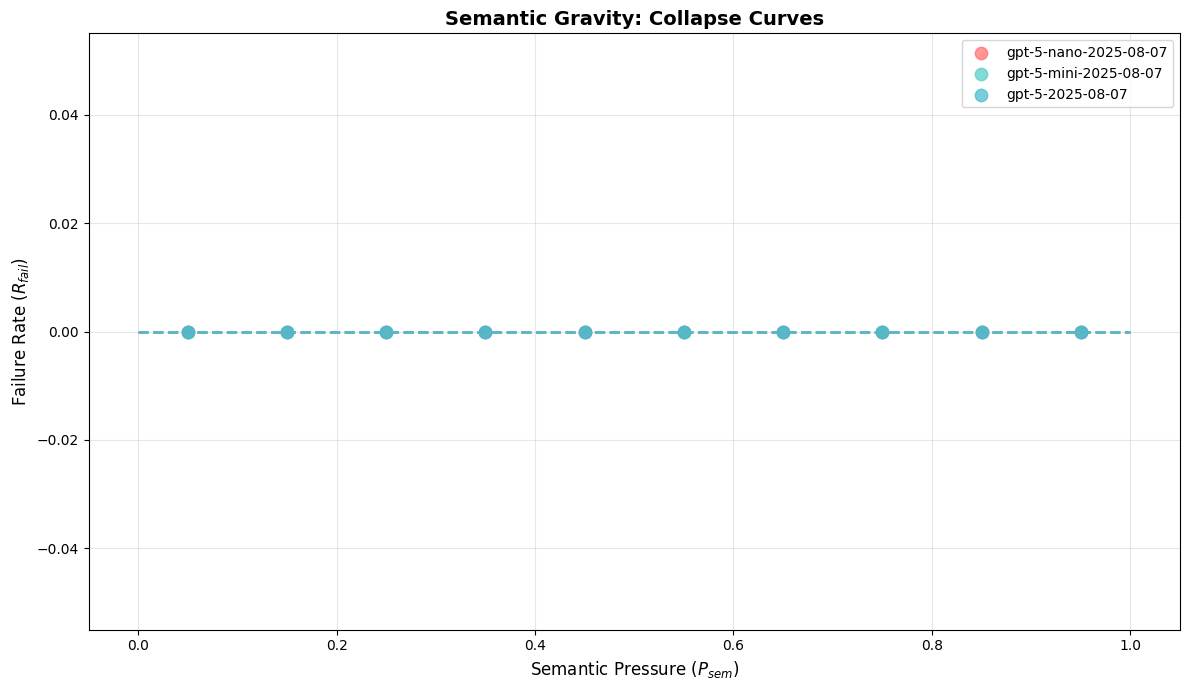

In [7]:
# =============================================================================
# Cell 11: Plot Collapse Curves
# =============================================================================

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

plt.figure(figsize=(12, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, model_name in enumerate(GPT_MODELS):
    # Check both local and Drive
    results_file = f"results_{model_name}.csv"
    drive_results_file = os.path.join(OUTPUT_PATH, results_file)

    if os.path.exists(drive_results_file):
        df = pd.read_csv(drive_results_file)
    elif os.path.exists(results_file):
        df = pd.read_csv(results_file)
    else:
        print(f"Results not found for {model_name}")
        continue

    # Binning
    bins = np.linspace(0, 1, 11)
    df['bin'] = pd.cut(df['p_sem'], bins, labels=bins[:-1])
    binned_data = df.groupby('bin')['failed'].mean().reset_index()
    binned_data['p_sem_mid'] = binned_data['bin'].astype(float) + 0.05
    binned_data = binned_data.dropna()

    # Plot Points
    plt.scatter(binned_data['p_sem_mid'], binned_data['failed'],
                label=f"{model_name}", alpha=0.7, s=80, color=colors[i])

    # Fit Curve
    try:
        if len(binned_data) > 4:
            p0 = [max(binned_data['failed']), np.median(binned_data['p_sem_mid']), 1, min(binned_data['failed'])]
            popt, _ = curve_fit(sigmoid, binned_data['p_sem_mid'], binned_data['failed'], p0=p0, maxfev=5000)
            x_model = np.linspace(0, 1, 100)
            y_model = sigmoid(x_model, *popt)
            plt.plot(x_model, y_model, '--', color=colors[i], alpha=0.7, linewidth=2)
    except Exception as e:
        print(f"Could not fit curve for {model_name}: {e}")

plt.title("Semantic Gravity: Collapse Curves", fontsize=14, fontweight='bold')
plt.xlabel("Semantic Pressure ($P_{sem}$)", fontsize=12)
plt.ylabel("Failure Rate ($R_{fail}$)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save to Drive
plot_path = os.path.join(OUTPUT_PATH, "collapse_curves.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.savefig("collapse_curves.png", dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")

plt.show()

## Step 5: Export All Results

In [8]:
# =============================================================================
# Cell 12: Export & Save All Results to Drive
# =============================================================================

import zipfile

# Create metadata
metadata = {
    'timestamp': datetime.now().isoformat(),
    'models': GPT_MODELS,
    'qwen_model': MODEL_PATH,
    'num_prompts': len(prompts_df),
    'data_path': DATA_PATH,
    'output_path': OUTPUT_PATH
}

metadata_file = os.path.join(OUTPUT_PATH, 'experiment_metadata.json')
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved: {metadata_file}")

# List of files to include
files_to_zip = [
    'prompts_with_synonyms.csv',
    'experiment_metadata.json',
    'collapse_curves.png',
    'batch_ids_exp2.json',
    'batch_ids_exp3.json'
]

# Add result files
for model in GPT_MODELS:
    files_to_zip.append(f'results_{model}.csv')
    files_to_zip.append(f'results_exp3_{model}.csv')

# Create zip in OUTPUT_PATH
output_zip = os.path.join(OUTPUT_PATH, 'semantic_gravity_results.zip')
with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        # Check both OUTPUT_PATH and local
        drive_file = os.path.join(OUTPUT_PATH, file)
        if os.path.exists(drive_file):
            zipf.write(drive_file, file)
            print(f"  Added: {file}")
        elif os.path.exists(file):
            zipf.write(file, file)
            print(f"  Added: {file}")
        else:
            print(f"  Warning: {file} not found")

print(f"\nAll results zipped: {output_zip}")
print(f"\n" + "="*50)
print("EXPERIMENT COMPLETE!")
print("="*50)
print(f"\nAll outputs saved to: {OUTPUT_PATH}")
print("\nFiles in output directory:")
for f in os.listdir(OUTPUT_PATH):
    size = os.path.getsize(os.path.join(OUTPUT_PATH, f)) / 1024
    print(f"  {f} ({size:.1f} KB)")

Metadata saved: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/experiment_metadata.json
  Added: prompts_with_synonyms.csv
  Added: experiment_metadata.json
  Added: collapse_curves.png
  Added: batch_ids_exp2.json
  Added: batch_ids_exp3.json
  Added: results_gpt-5-nano-2025-08-07.csv
  Added: results_exp3_gpt-5-nano-2025-08-07.csv
  Added: results_gpt-5-mini-2025-08-07.csv
  Added: results_exp3_gpt-5-mini-2025-08-07.csv
  Added: results_gpt-5-2025-08-07.csv
  Added: results_exp3_gpt-5-2025-08-07.csv

All results zipped: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output/semantic_gravity_results.zip

EXPERIMENT COMPLETE!

All outputs saved to: /content/drive/MyDrive/Projects/5_Semantic_Gravity_RP/output

Files in output directory:
  prompts_with_psem.csv (84.8 KB)
  prompts_with_qwen_results.csv (138.8 KB)
  prompts_with_synonyms.csv (142.7 KB)
  batch_requests_gpt-5-nano-2025-08-07.jsonl (263.0 KB)
  batch_requests_gpt-5-mini-2025-08-07.jsonl (263.0 KB)
  batc